## Objective : 

- Analyzing the drivers data for the insights,
- Depending on various variables or features, predict whether driver will churn or not from the company.

**column profiling**


- MMMM-YY : Reporting Date (Monthly) <br>
- Driver_ID : Unique id for drivers <br>
- Age : Age of the driver <br>
- Gender : Gender of the driver – Male : 0, Female: 1 <br>
- City : City Code of the driver <br>
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate <br>
- Income : Monthly average Income of the driver <br>
- Date Of Joining : Joining date for the driver <br>
- LastWorkingDate : Last date of working for the driver <br>
- Joining Designation : Designation of the driver at the time of joining <br>
- Grade : Grade of the driver at the time of reporting <br>
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments) <br>
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better) <br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
df = pd.read_csv('./online_ride_sharing_company_data.csv')

In [3]:
df.head()

Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level   
0           0  01/01/19          1  28.0     0.0  C23                2  \
1           1  02/01/19          1  28.0     0.0  C23                2   
2           2  03/01/19          1  28.0     0.0  C23                2   
3           3  11/01/20          2  31.0     0.0   C7                2   
4           4  12/01/20          2  31.0     0.0   C7                2   

   Income Dateofjoining LastWorkingDate  Joining Designation  Grade   
0   57387      24/12/18             NaN                    1      1  \
1   57387      24/12/18             NaN                    1      1   
2   57387      24/12/18        03/11/19                    1      1   
3   67016      11/06/20             NaN                    2      2   
4   67016      11/06/20             NaN                    2      2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 2  
2                     0                 2  
3                     0                 1  
4                     0                 1

Dropping the redundant columns.

In [4]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [6]:
# changing the data type of date columns
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])


C:\Users\A Singh\AppData\Local\Temp\ipykernel_5116\838972859.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
C:\Users\A Singh\AppData\Local\Temp\ipykernel_5116\838972859.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
C:\Users\A Singh\AppData\Local\Temp\ipykernel_5116\838972859.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])


In [7]:
# switching the city codes to int type
df['City'] = df['City'].apply(lambda x: int(x[1:]))

In [8]:
# counting duplicates in data
df.duplicated().sum()

0

In [9]:
# Null values in dataset
100*df.isna().sum()/df.shape[0]

MMM-YY                   0.000000
Driver_ID                0.000000
Age                      0.319305
Gender                   0.272194
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
LastWorkingDate         91.541039
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

There are no duplicates in the dataset. The max. null values are present in *LastWorkingDate* feature, followed by *Gender* and *Age* which are less than 0.5%. So, we can just drop them from our dataset.

In [10]:
df2 = df[(df['Age'].notna()) & (df['Gender'].notna())]

In [11]:
# % rows lost
print('% of data lost:', (df.shape[0] - df2.shape[0])*100/df.shape[0])

% of data lost: 0.591499162479062


There is only 0.59% of data loss, which is not significant.

###  Feature Engineering, and processing

In [12]:
df3 = df2.copy()

In [13]:
df3= df3.groupby(["Driver_ID"],sort = False).agg(
    Count_drivers_reported = ('MMM-YY','count'),
    Age = ('Age','last'),
    Gender = ("Gender",'first'),
    City = ("City",'last'),
    Education_level = ('Education_Level','last'),
    Income_first = ('Income','first'),
    Income_last = ('Income','last'),
    Dateofjoining_last = ('Dateofjoining','last'),
    LastWorkingDate_last = ('LastWorkingDate','last'),
    Joining_Designation = ("Joining Designation",'last'),
    Grade = ("Grade",'last'),
    Total_Business_Value = ('Total Business Value','sum'),
    Quarterly_Rating_first = ("Quarterly Rating",'first'),
    Quarterly_Rating_last = ("Quarterly Rating",'last'),
#     joining_month = ('joining_year','last'),
#     joining_year = ('joining_month','last'),
#     target = ('target','last')    
).reset_index()

In [14]:
# creating features for joining month and year
df3['joining_year'] = df3['Dateofjoining_last'].dt.year
df3['joining_month'] = df3['Dateofjoining_last'].dt.month

# feature for whether quarterly rating increased or not
df3["Quarterly_Rating_inc"] = [1 if i>0 else 0 for i in df3["Quarterly_Rating_last"] - df3["Quarterly_Rating_first"] ]

# feature capturing whether income increased or not
df3['Income_raise_inc'] = [1 if x > 0 else 0 for x in  df3['Income_last'] - df3['Income_first']]

# months drived by the drivers before leaving the company
df3['months_drived'] = (df3['LastWorkingDate_last'] - df3['Dateofjoining_last'])/np.timedelta64(1,'M')
# Drivers who are still driving for the company will be represented by -1
df3['months_drived'] = df3['months_drived'].fillna(-1)

# creating target variable
df3['target'] = np.where(df3['LastWorkingDate_last'].dt.date.isnull(),1,0) # 0: churned 1: not churned

In [15]:
df3.isna().sum()

Driver_ID                   0
Count_drivers_reported      0
Age                         0
Gender                      0
City                        0
Education_level             0
Income_first                0
Income_last                 0
Dateofjoining_last          0
LastWorkingDate_last      775
Joining_Designation         0
Grade                       0
Total_Business_Value        0
Quarterly_Rating_first      0
Quarterly_Rating_last       0
joining_year                0
joining_month               0
Quarterly_Rating_inc        0
Income_raise_inc            0
months_drived               0
target                      0
dtype: int64

Next, we will drop all the un-necessary columns.

In [16]:
df3.drop(['Driver_ID','Income_first','Dateofjoining_last','LastWorkingDate_last','Quarterly_Rating_first','Quarterly_Rating_last'], axis = 1, inplace = True)

In [17]:
df3 = df3.rename(columns = {'Count_drivers_reported':'reporting_count',
                      'Age':'age',
                      'Gender':'gender',
                      'City':'city',
                      'Education_level':'education_level',
                      'Income_last':'income',
                      'Joining_Designation':'joining_designation',
                      'Grade':'grade',
                      'Total_Business_value':'tbv',
                      'Quarterly_Rating_inc':'quarterly_rating_inc',
                      'Income_raise_inc':'income_raise_inc',
                     })

### Univariate Analysis

% of drivers as per gender:  gender
0.0    0.589668
1.0    0.410332
Name: proportion, dtype: float64


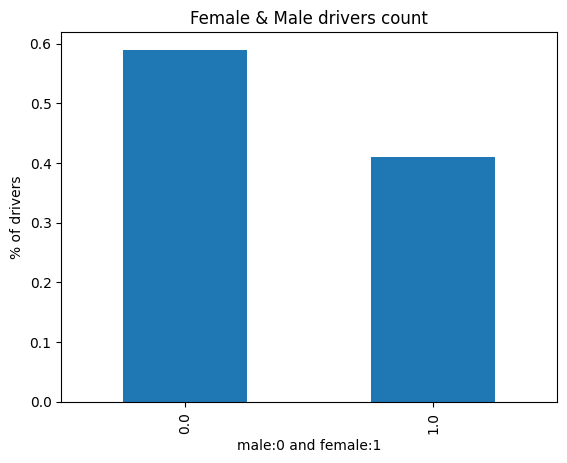

In [18]:
print('% of drivers as per gender: ',df3['gender'].value_counts(normalize = True))
plt.title("Female & Male drivers count")
df3['gender'].value_counts(normalize = True).plot(kind = 'bar')
plt.xlabel("male:0 and female:1")
plt.ylabel('% of drivers')
plt.savefig('./Female & Male drivers count.jpeg')

Females count is not insignificant among drivers. This is a good sign for females who can drive.

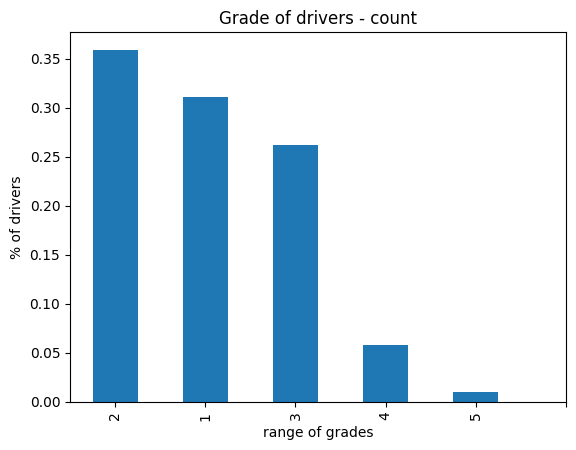

In [19]:
plt.title("Grade of drivers - count")
df3['grade'].value_counts(normalize = True).plot(kind = 'bar')
plt.xlabel("range of grades")
plt.xticks( np.arange(6))
plt.ylabel('% of drivers')
plt.savefig('./Grade of drivers - count.jpeg')
plt.show()

Majority of drivers belong to Grade 2,Grade 1 . Least number of drivers belong to Grade 5

joining_designation
1    0.430911
2    0.342293
3    0.207056
4    0.015120
5    0.004620
Name: proportion, dtype: float64


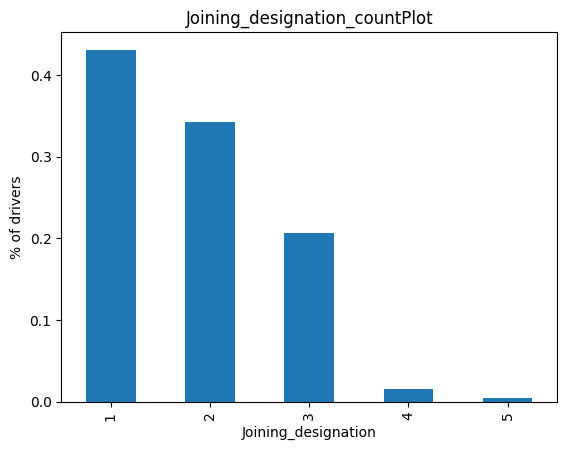

In [20]:
print(df3['joining_designation'].value_counts(normalize = True))
plt.title("Joining_designation_countPlot")
df3['joining_designation'].value_counts(normalize = True).plot(kind = 'bar')
plt.xlabel("Joining_designation")
plt.ylabel('% of drivers')
plt.savefig('./Joining_designation_countPlot.jpeg')

Most of the drivers belong teh Joining_designation of 1 and 2.Least belong to designation 5.

education_level
2    0.336833
1    0.333893
0    0.329273
Name: proportion, dtype: float64


Text(0, 0.5, '% of drivers')

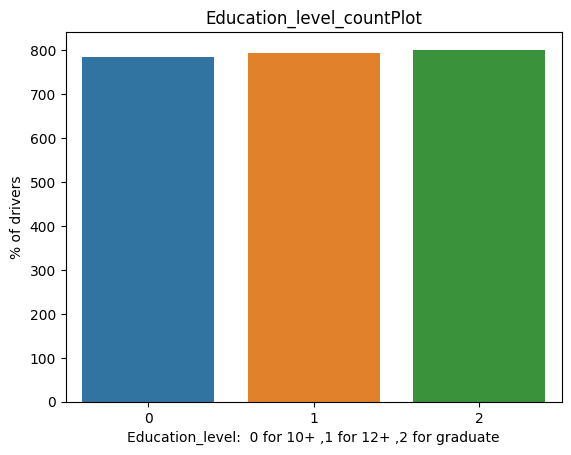

In [21]:
print(df3['education_level'].value_counts(normalize = True))
plt.title("Education_level_countPlot")
sns.countplot(x = 'education_level',data = df3)
plt.xlabel('Education_level:  0 for 10+ ,1 for 12+ ,2 for graduate')
plt.ylabel('% of drivers')

Drivers are almost equally distributed in terms of Education. 

Text(0.5, 1.0, 'Boxplot for Age of drivers')

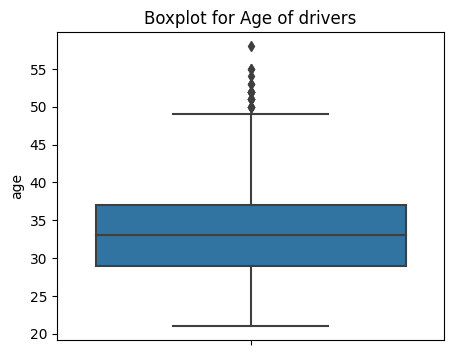

In [22]:
plt.figure(figsize = (5,4))
sns.boxplot(y = 'age',data = df3)
plt.title('Boxplot for Age of drivers')

Median age of drivers is around 33 years.

Text(0.5, 1.0, 'Boxplot for total_business_value of drivers')

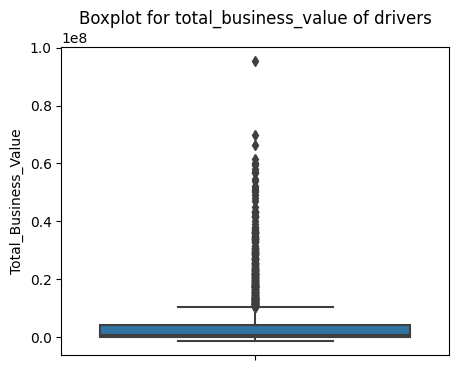

In [23]:
plt.figure(figsize = (5,4))
sns.boxplot(y = 'Total_Business_Value',data = df3)
plt.title('Boxplot for total_business_value of drivers')

<Axes: xlabel='Total_Business_Value', ylabel='Count'>

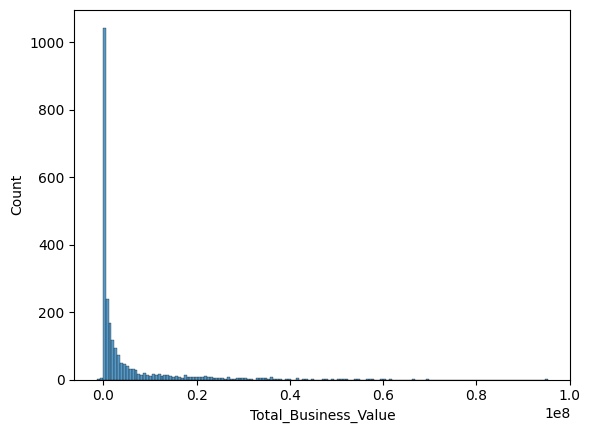

In [24]:
sns.histplot(df3['Total_Business_Value'])

The plot is rightly skewed, so needs to be standardized. We will do it later on.

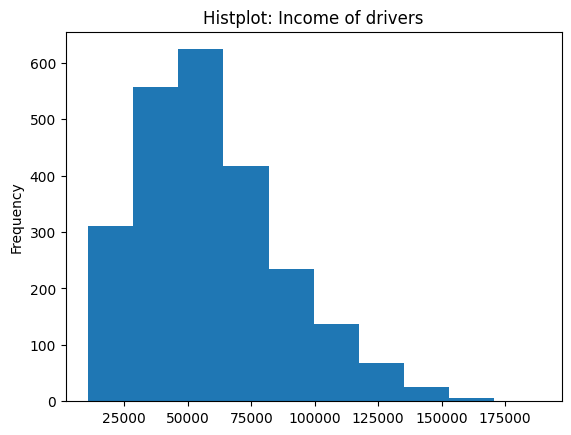

In [25]:
plt.title("Histplot: Income of drivers")
df3['income'].plot(kind = 'hist')
plt.savefig('./Histplot: Income of drivers.jpeg')

Most of the drivers earn between 40,000 and 70,000 monthly.

quarterly_rating_inc
0    85.0063
1    14.9937
Name: proportion, dtype: float64


Text(0, 0.5, '% of drivers')

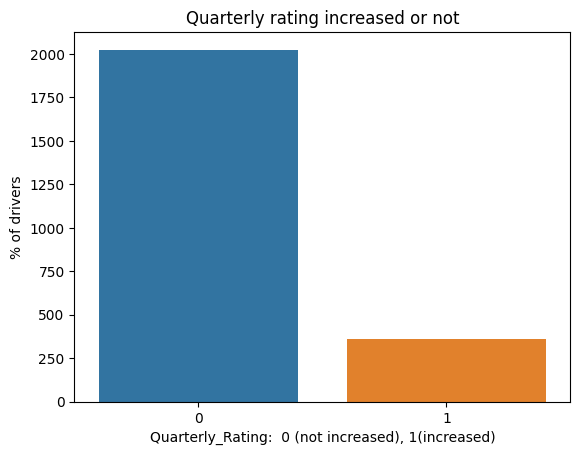

In [26]:
print((df3['quarterly_rating_inc'].value_counts(normalize =True))*100)


plt.title("Quarterly rating increased or not")
sns.countplot(x = 'quarterly_rating_inc',data = df3)

plt.xlabel('Quarterly_Rating:  0 (not increased), 1(increased)')
plt.ylabel('% of drivers')

85% of the drivers have not achieved any increment in their salary and only 15% have got increment.

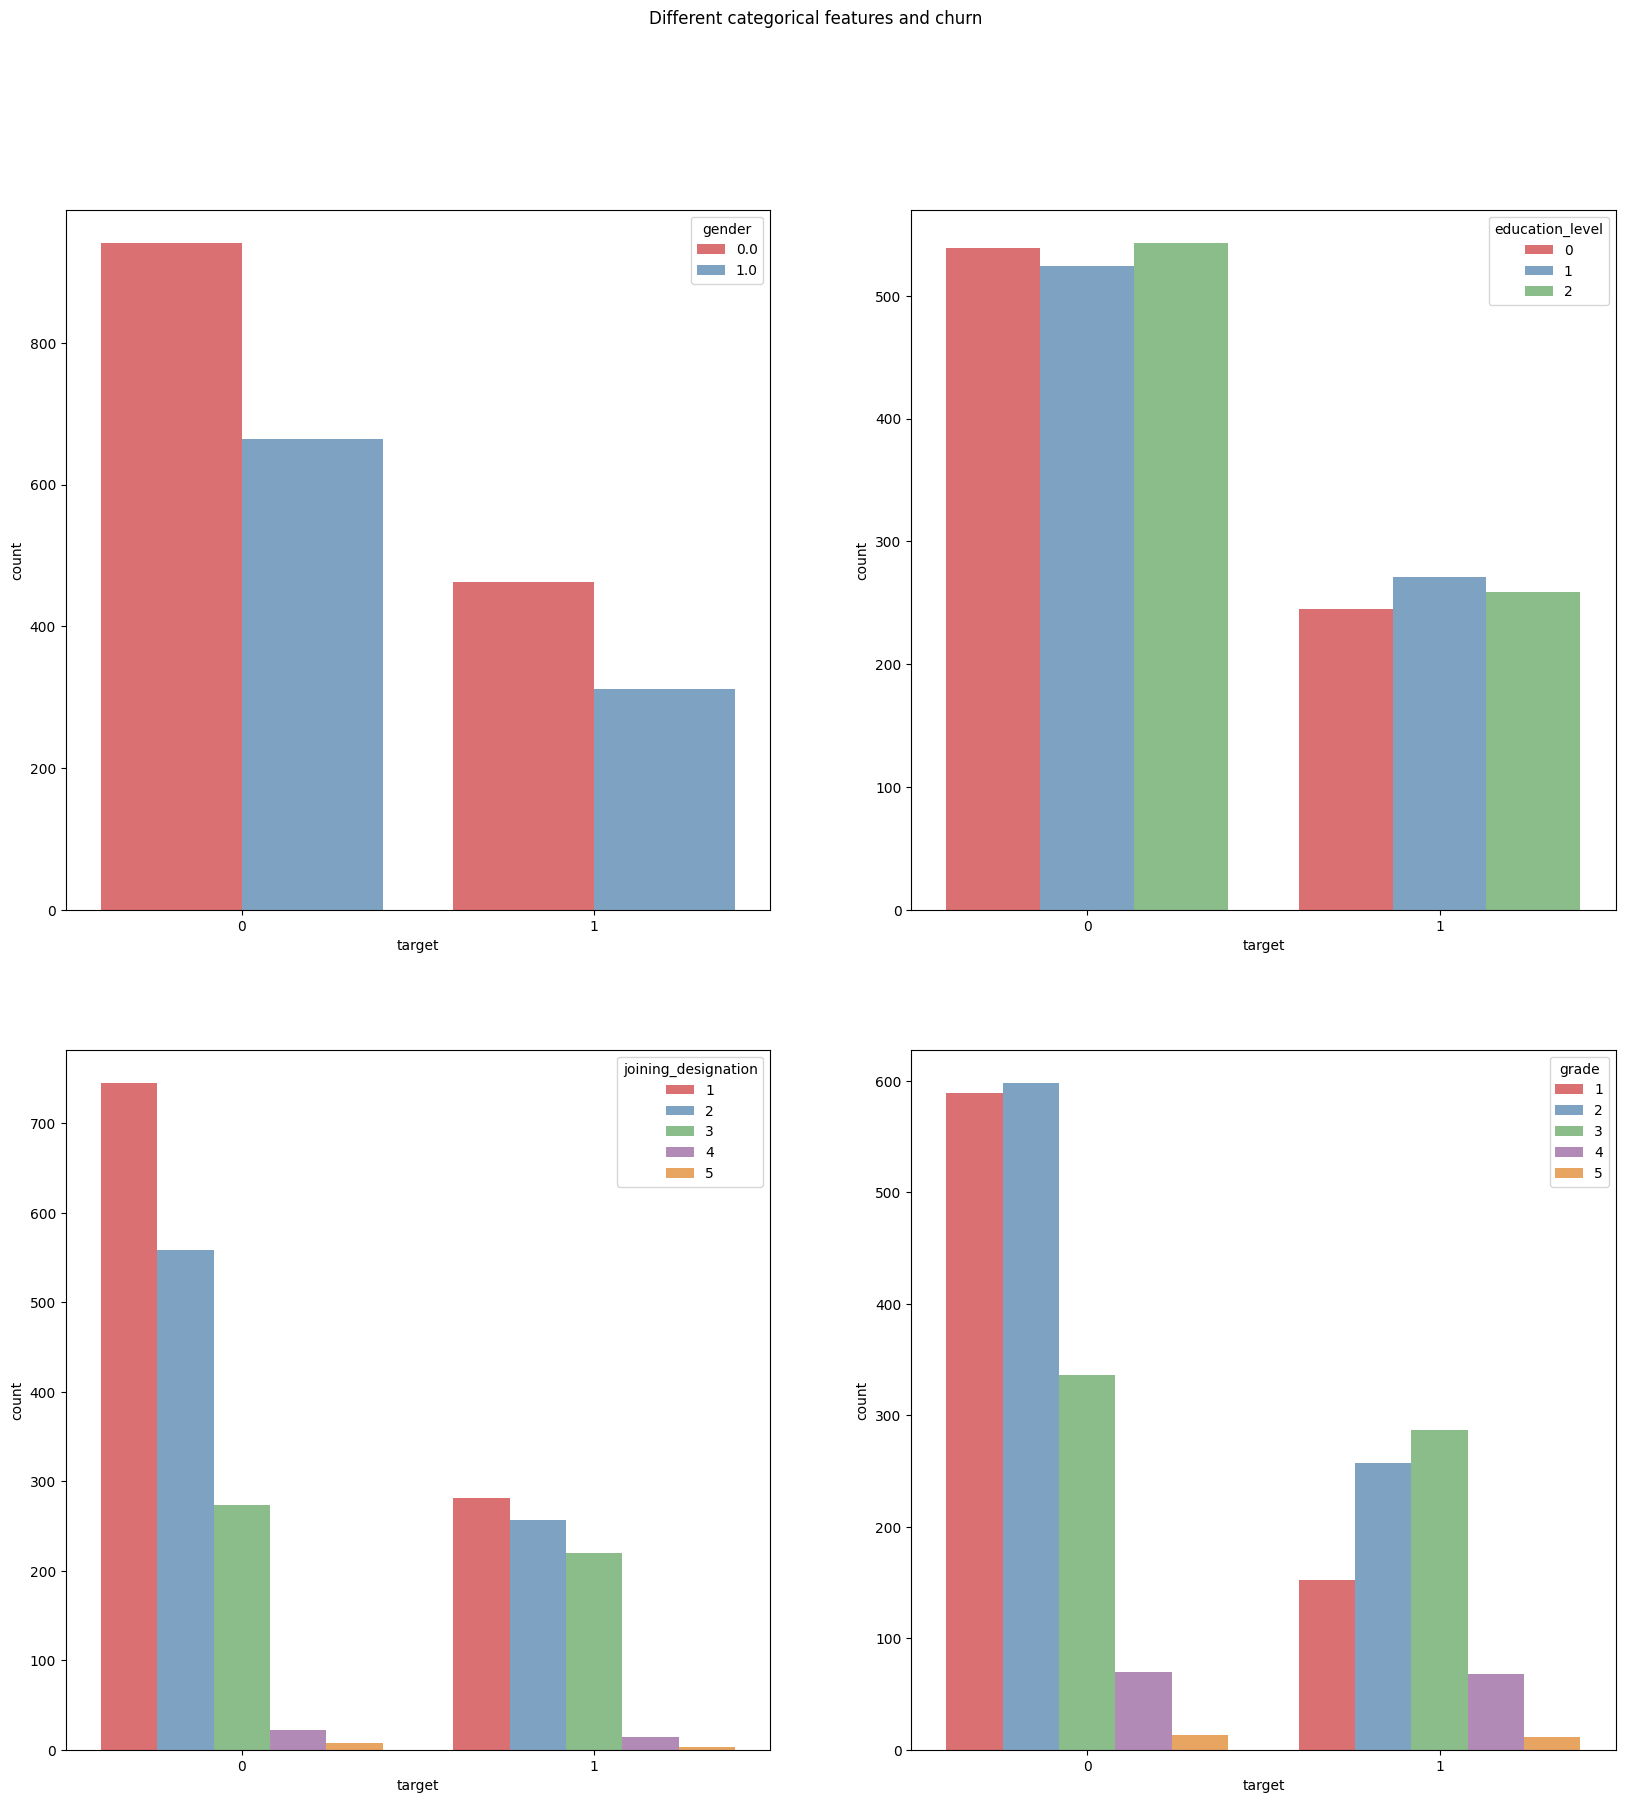

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))
axs = axs.flatten()
fig.suptitle('Different categorical features and churn')
categorical2 = ['gender', 'education_level','joining_designation','grade']
for ax, i in enumerate(categorical2):
    sns.countplot(x='target', alpha=0.7, hue=i, data=df3, ax=axs[ax],palette='Set1')

###### Observation
- Similar pattern is observed in Gender,joining_designation,and education level category in case of churning.
- Grade 3 Drivers are churning more.
- Drivers with high Quarterly ratig are also churning at fast rate.

### Bivariate Analysis

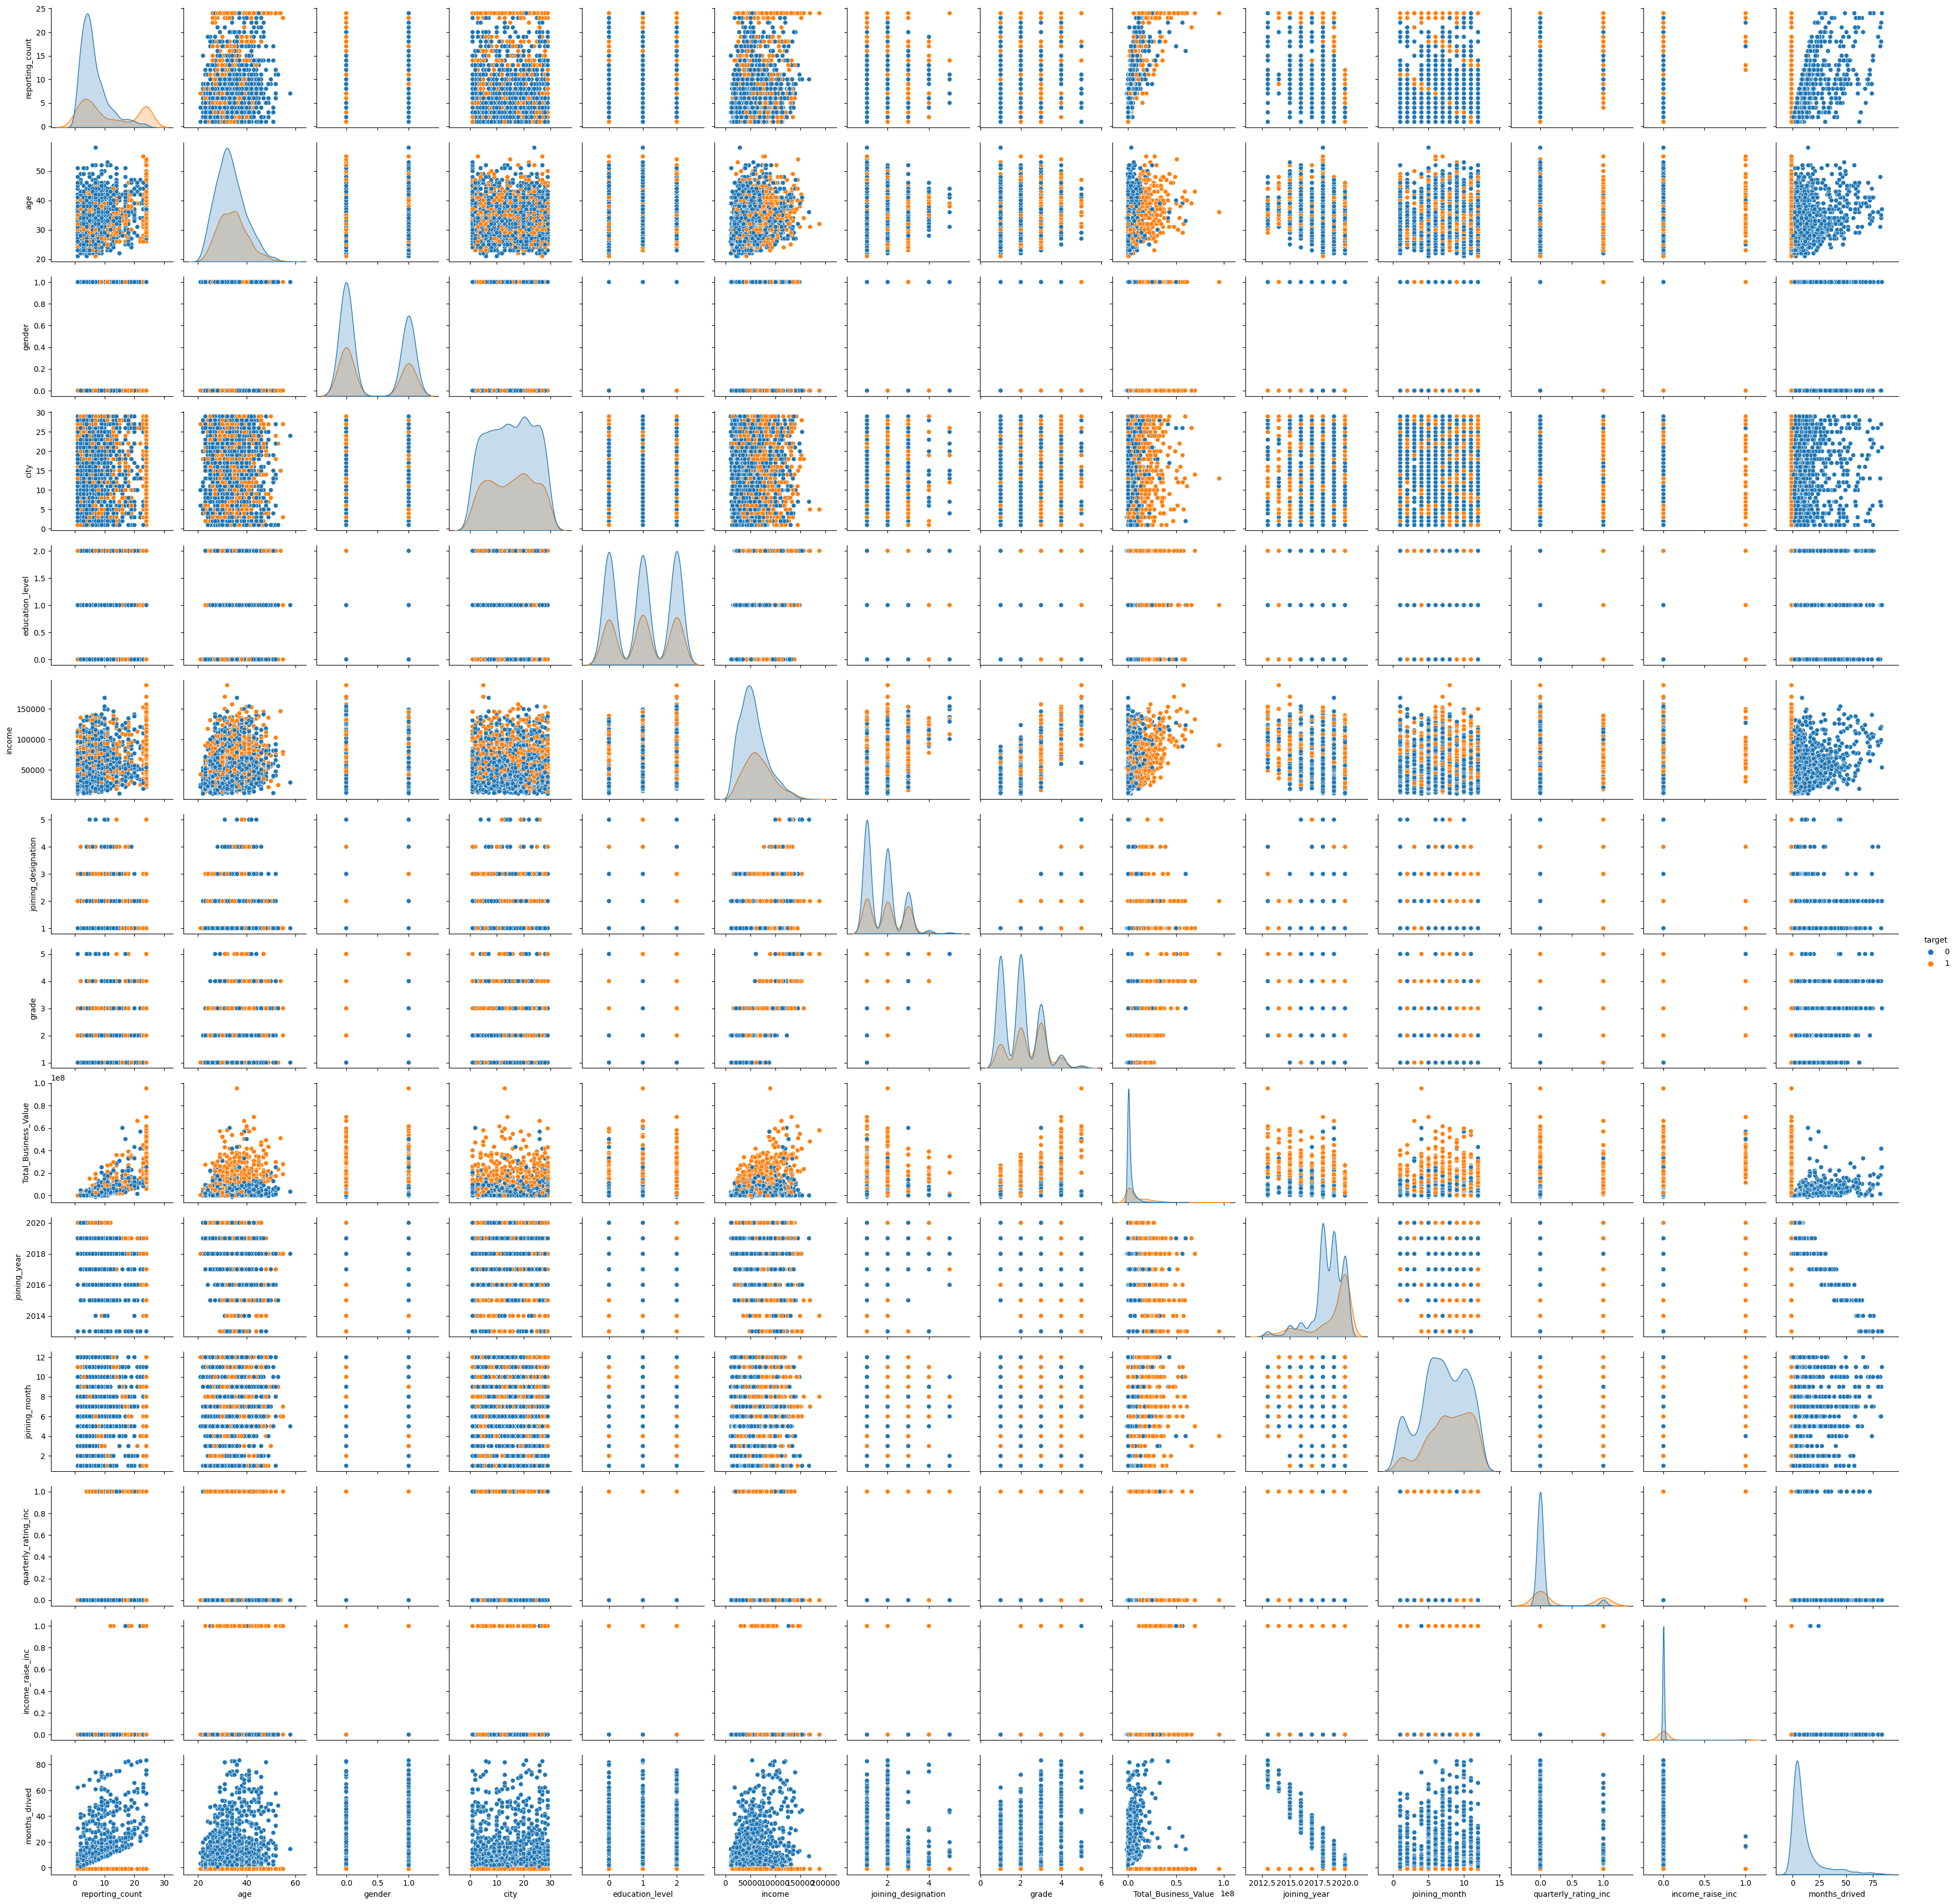

In [28]:
sns.pairplot(df3, hue = 'target')

#### Statistical Summary

In [29]:
df3.describe()

reporting_count          age       gender         city   
count      2381.000000  2381.000000  2381.000000  2381.000000  \
mean          7.976060    33.662747     0.410332    15.335573   
std           6.765944     5.983598     0.491997     8.371843   
min           1.000000    21.000000     0.000000     1.000000   
25%           3.000000    29.000000     0.000000     8.000000   
50%           5.000000    33.000000     0.000000    15.000000   
75%          10.000000    37.000000     1.000000    22.000000   
max          24.000000    58.000000     1.000000    29.000000   

       education_level         income  joining_designation        grade   
count       2381.00000    2381.000000          2381.000000  2381.000000  \
mean           1.00756   59334.157077             1.820244     2.096598   
std            0.81629   28383.666384             0.841433     0.941522   
min            0.00000   10747.000000             1.000000     1.000000   
25%            0.00000   39104.000000             1.000000     1.000000   
50%            1.00000   55315.000000             2.000000     2.000000   
75%            2.00000   75986.000000             2.000000     3.000000   
max            2.00000  188418.000000             5.000000     5.000000   

       Total_Business_Value  joining_year  joining_month   
count          2.381000e+03   2381.000000    2381.000000  \
mean           4.571152e+06   2018.536329       7.357413   
std            9.109932e+06      1.609597       3.143143   
min           -1.385530e+06   2013.000000       1.000000   
25%            0.000000e+00   2018.000000       5.000000   
50%            8.070400e+05   2019.000000       7.000000   
75%            4.154190e+06   2020.000000      10.000000   
max            9.533106e+07   2020.000000      12.000000   

       quarterly_rating_inc  income_raise_inc  months_drived       target  
count           2381.000000       2381.000000    2381.000000  2381.000000  
mean               0.149937          0.018060       7.474062     0.325493  
std                0.357085          0.133195      13.465057     0.468657  
min                0.000000          0.000000      -1.000000     0.000000  
25%                0.000000          0.000000      -1.000000     0.000000  
50%                0.000000          0.000000       3.258065     0.000000  
75%                0.000000          0.000000       8.290323     1.000000  
max                1.000000          1.000000      83.290323     1.000000

###### Observation
- Median age, education, Income,Joining_desination,Total_busines_value,Quarterly_rating of drivers: 33 years,1, 55000, 2, 817680, and 1 respectively.
- min Age of driver : 21 Years and max age: 58 years.
- max Education Level : 2 (ie. Graduate)

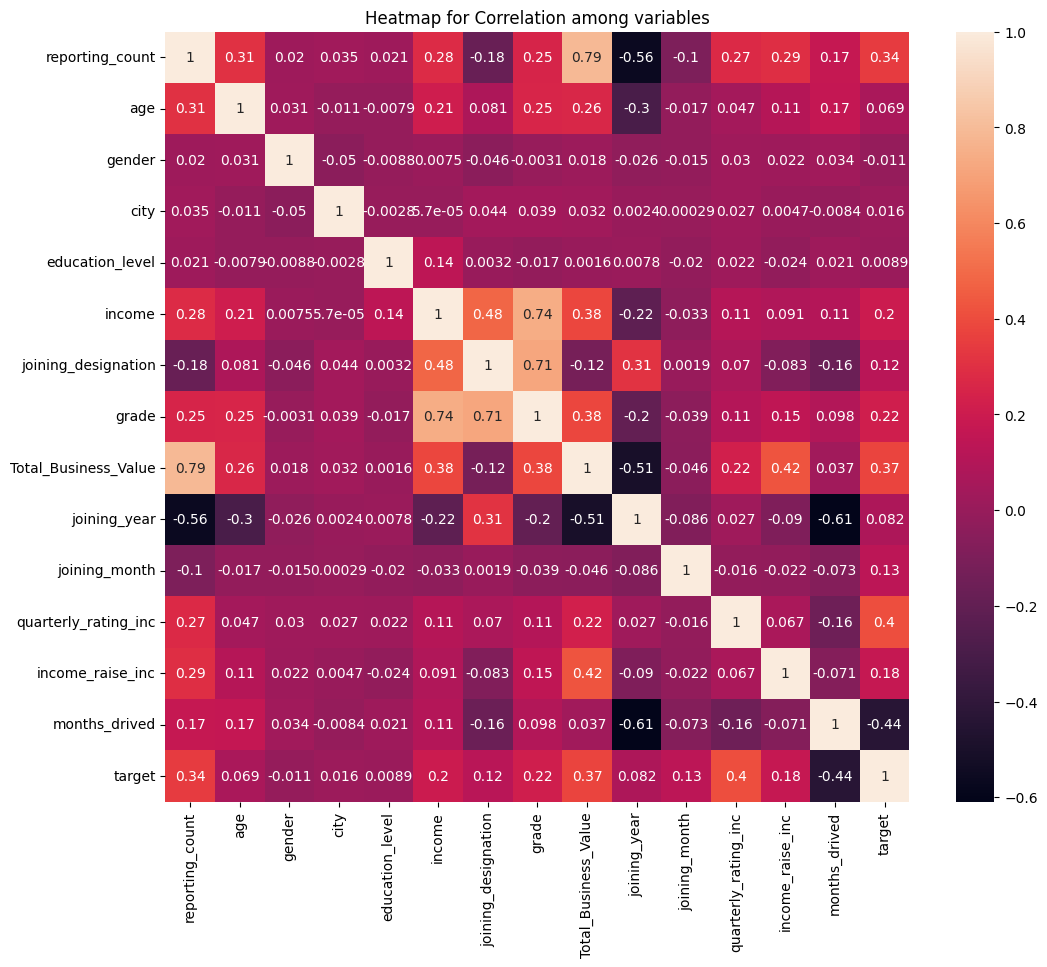

In [30]:
plt.figure(figsize = (12,10))
sns.heatmap(df3.corr(),annot = True )
plt.title("Heatmap for Correlation among variables")
plt.savefig('./Heatmap for Correlation among variables.jpeg')
plt.show()

As per this plot, a positive correlation exists between number of times driver have to report and total business values by the driver. <br>
In addition, similar is the case with grade-income and grade-joining-designation.

income_raise_inc
0    98.194036
1     1.805964
Name: proportion, dtype: float64


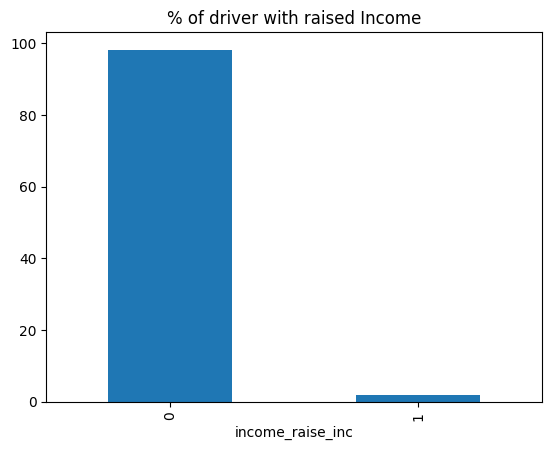

In [31]:
print(df3['income_raise_inc'].value_counts(normalize = True)*100)
plt.title("% of driver with raised Income")
(df3['income_raise_inc'].value_counts(normalize = True)*100).plot(kind = 'bar')
plt.savefig('./% of driver with raised Income.jpeg')

This shows that there are only a 1.8% of drivers who have managed to raise their income. Which is another negative sign for the company, as this will discourage the new drivers to join the company.

**How many months drivers have driven before leaving the company?**

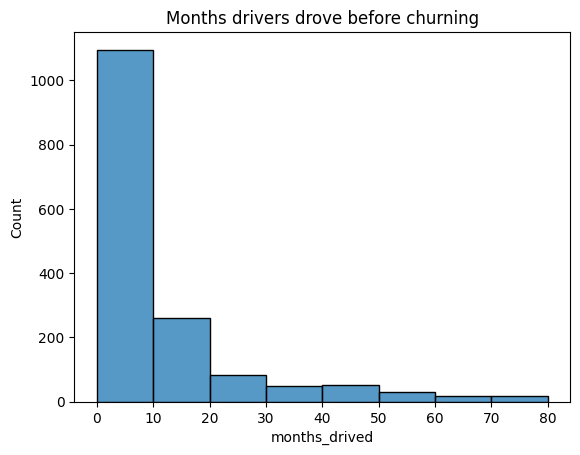

In [32]:
plt.title("Months drivers drove before churning")
sns.histplot(df3['months_drived'], bins = np.arange(0,90,10))
plt.savefig('./Months drivers drove before churning.jpeg')

The above plot shows that there most of the drivers have drived only for around 10 months. Which is not a good sign for the company. This indicates the disappointment among drivers for the company. <br>
<br>
In *Months_Drived* feature for the drivers who haven't churned yet as `-1`.

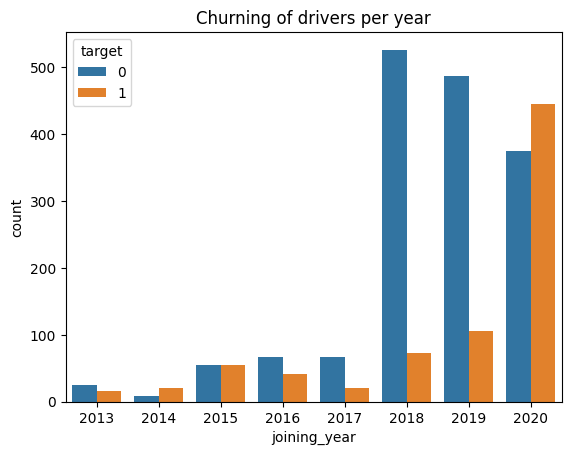

In [33]:
plt.title("Churning of drivers per year")
sns.countplot(x = df3['joining_year'],hue = 'target', data = df3)
plt.savefig('./Churning of drivers per year.jpeg')

Max churning was observed in the year 2020 possibly due to covid. Before 2020, many driver have joined the company and also churn rate was low.

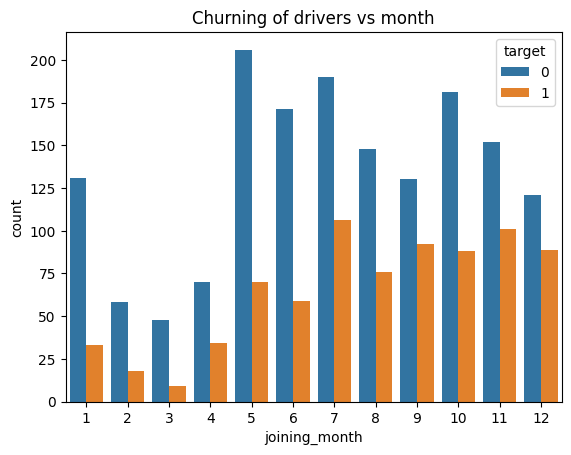

In [34]:
plt.title("Churning of drivers vs month")
sns.countplot(x = df3['joining_month'],hue = 'target', data = df3)
plt.savefig('./Churning of drivers vs month.jpeg')

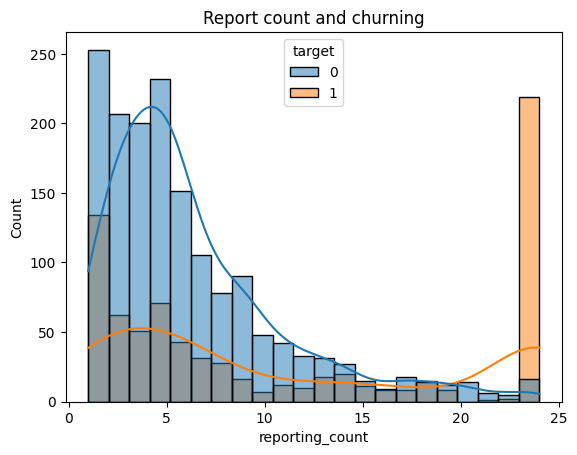

In [35]:
plt.title("Report count and churning")
sns.histplot(data=df3, x="reporting_count",hue = 'target', kde = True)
plt.savefig('./Report count and churning.jpeg')

In [36]:
df3.describe()

reporting_count          age       gender         city   
count      2381.000000  2381.000000  2381.000000  2381.000000  \
mean          7.976060    33.662747     0.410332    15.335573   
std           6.765944     5.983598     0.491997     8.371843   
min           1.000000    21.000000     0.000000     1.000000   
25%           3.000000    29.000000     0.000000     8.000000   
50%           5.000000    33.000000     0.000000    15.000000   
75%          10.000000    37.000000     1.000000    22.000000   
max          24.000000    58.000000     1.000000    29.000000   

       education_level         income  joining_designation        grade   
count       2381.00000    2381.000000          2381.000000  2381.000000  \
mean           1.00756   59334.157077             1.820244     2.096598   
std            0.81629   28383.666384             0.841433     0.941522   
min            0.00000   10747.000000             1.000000     1.000000   
25%            0.00000   39104.000000             1.000000     1.000000   
50%            1.00000   55315.000000             2.000000     2.000000   
75%            2.00000   75986.000000             2.000000     3.000000   
max            2.00000  188418.000000             5.000000     5.000000   

       Total_Business_Value  joining_year  joining_month   
count          2.381000e+03   2381.000000    2381.000000  \
mean           4.571152e+06   2018.536329       7.357413   
std            9.109932e+06      1.609597       3.143143   
min           -1.385530e+06   2013.000000       1.000000   
25%            0.000000e+00   2018.000000       5.000000   
50%            8.070400e+05   2019.000000       7.000000   
75%            4.154190e+06   2020.000000      10.000000   
max            9.533106e+07   2020.000000      12.000000   

       quarterly_rating_inc  income_raise_inc  months_drived       target  
count           2381.000000       2381.000000    2381.000000  2381.000000  
mean               0.149937          0.018060       7.474062     0.325493  
std                0.357085          0.133195      13.465057     0.468657  
min                0.000000          0.000000      -1.000000     0.000000  
25%                0.000000          0.000000      -1.000000     0.000000  
50%                0.000000          0.000000       3.258065     0.000000  
75%                0.000000          0.000000       8.290323     1.000000  
max                1.000000          1.000000      83.290323     1.000000

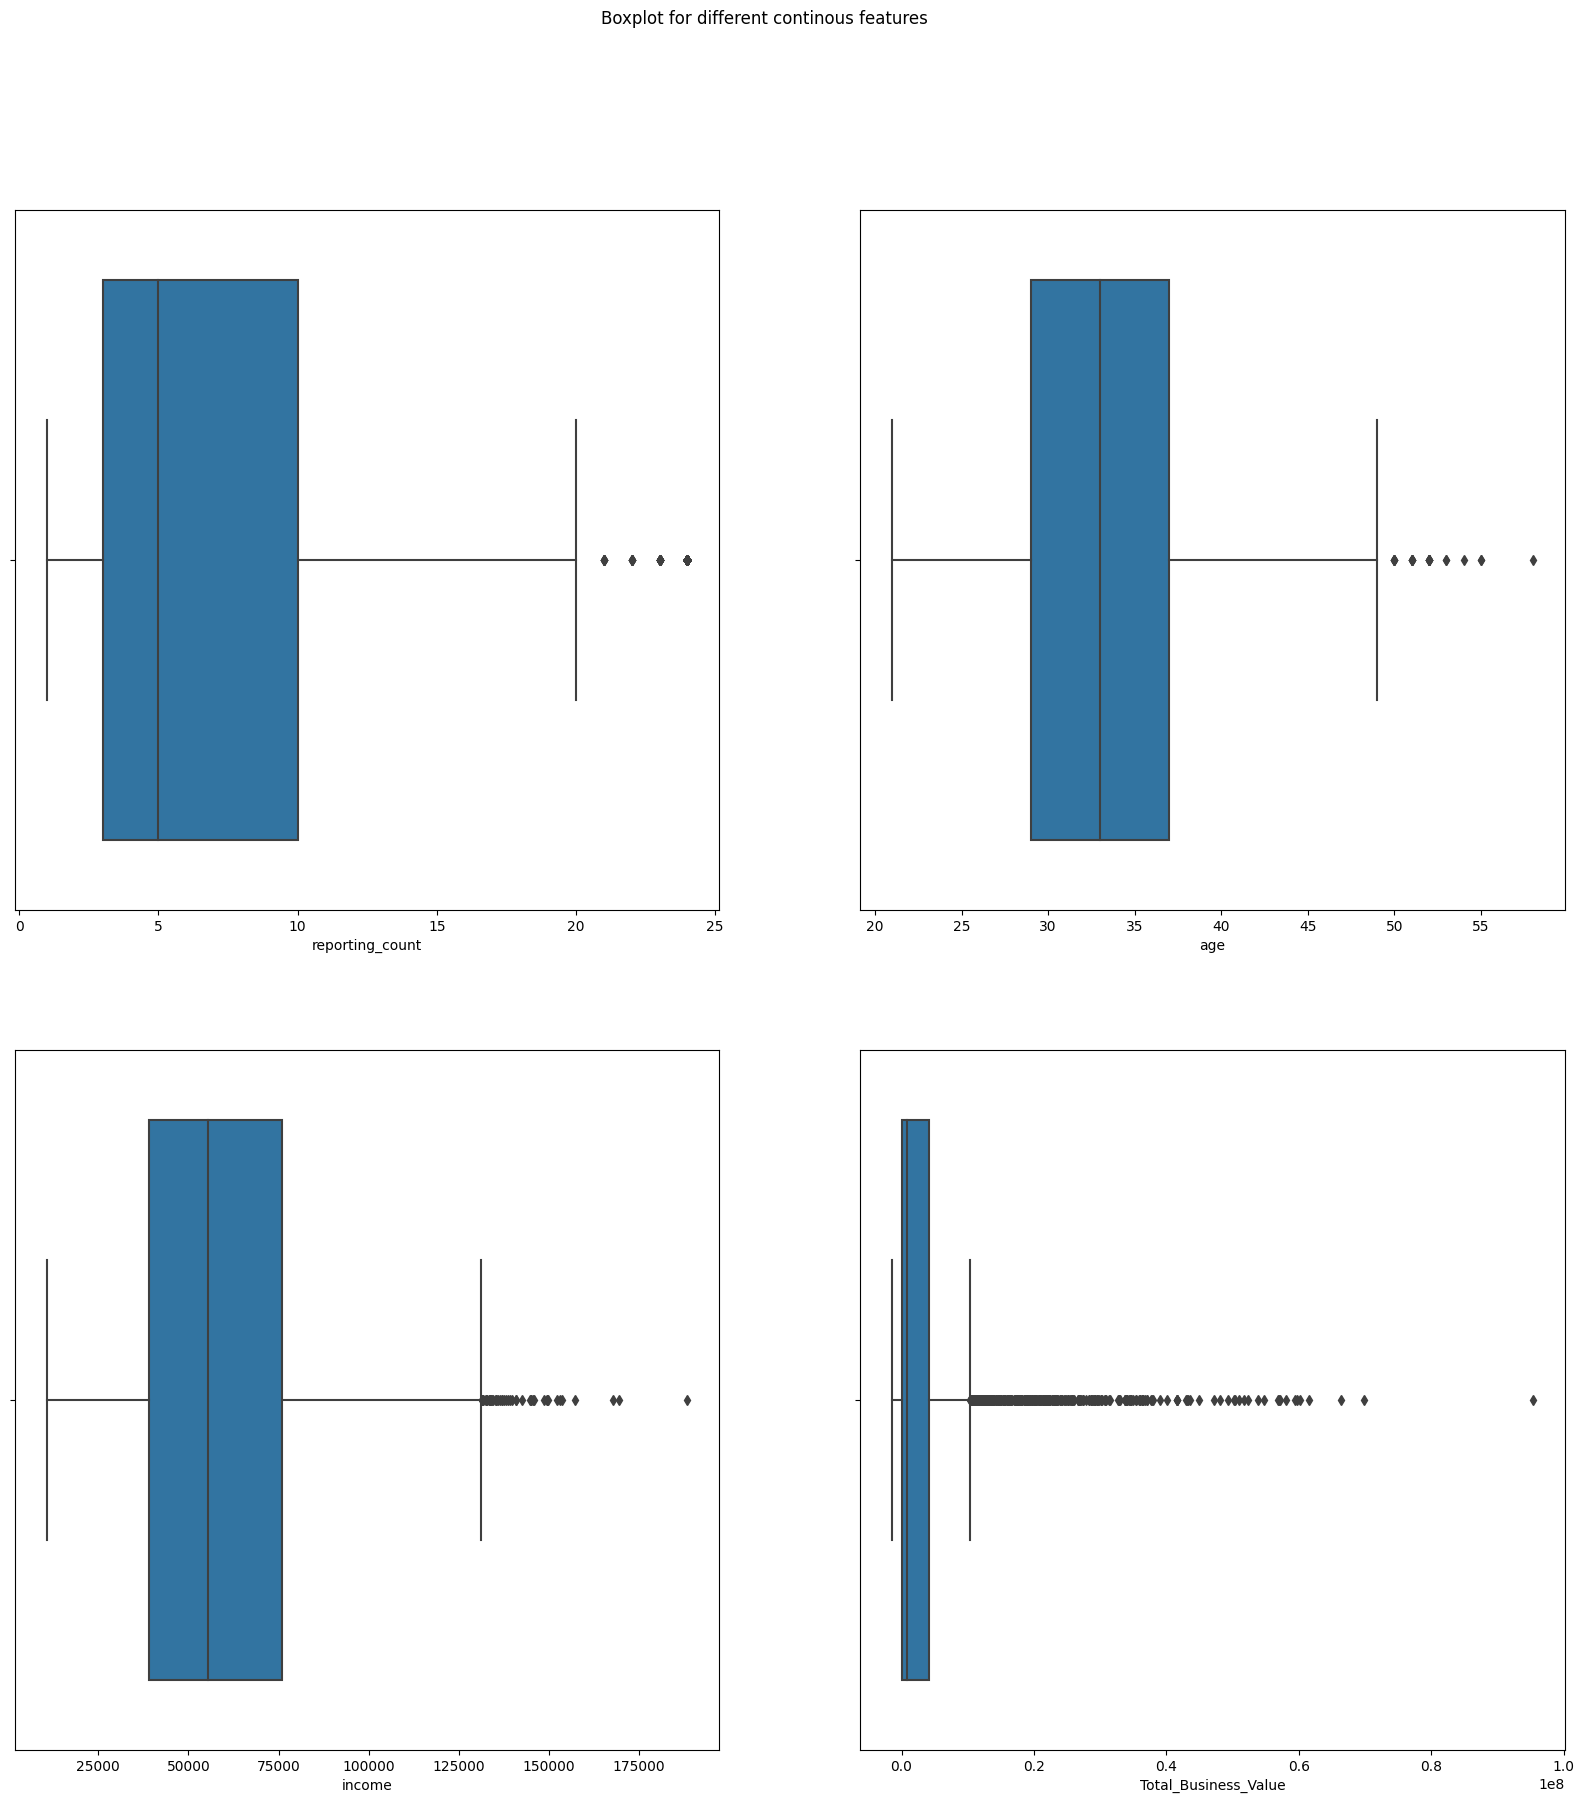

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))
axs = axs.flatten()
fig.suptitle('Boxplot for different continous features')
categorical2 = ['reporting_count', 'age', 'income', 'Total_Business_Value']
for ax, i in enumerate(categorical2):
    sns.boxplot(x= i,  data=df3, ax=axs[ax])

In [38]:
q1 = df3['Total_Business_Value'].quantile(0.25)
q3 = df3['Total_Business_Value'].quantile(0.75)
iqr = q3 - q1
df_new3 = df3.loc[(df3['Total_Business_Value'] >= (q1 - 1.5*iqr)) & (df3['Total_Business_Value'] <= (q3 + 1.5*iqr))]

print(f"Data loss : {round((df3.shape[0] - df_new3.shape[0])*100/df3.shape[0],3)}%")

Data loss : 14.196%


### Pre-Processing before modelling

In [39]:
X = df3.drop(['target'], axis = 1)
y = df3['target']

**Train test split**

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

**Standardization**

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Imbalance data check**

In [42]:
y_train.value_counts(normalize  = True)*100

target
0    67.384454
1    32.615546
Name: proportion, dtype: float64

The data is imbalanced as there are 67.38% of the drivers who have churned from the company, while there are only 32.61% of the drivers who have chosen to stay with the company. <br>
<br> 
Now, there are several techniques to handle imbalance data. For this we have chosen oversampling using SMOTE.

**Data imbalance handling: Oversampling with SMOTE**

In [43]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_sm,y_sm = smt.fit_resample(X_train,y_train)

### Modelling

### 1. Logistic Regression

In [44]:
#initialization
model_lr = LogisticRegression(C = 1)

#fitting
model_lr.fit(X_sm,y_sm)

# prediction
y_pred_lr = model_lr.predict(X_test)

In [45]:
from sklearn.metrics import f1_score,roc_auc_score,precision_score,recall_score, classification_report

In [46]:
f1_score_lr = round(f1_score(y_test,y_pred_lr),3)
roc_auc_score_lr = round(roc_auc_score(y_test,y_pred_lr),3)
precision_lr = round(precision_score(y_test,y_pred_lr),3)
recall_lr = round(recall_score(y_test,y_pred_lr),3)

print(f"F1 score for Logistic Regression: {f1_score_lr}")
print(f"ROC-AUC score for Logistic Regression: {roc_auc_score_lr}")
print(f"Precision score for Logistic Regression: {precision_lr}")
print(f"Recall score for Logistic Regression: {recall_lr}")

F1 score for Logistic Regression: 0.984
ROC-AUC score for Logistic Regression: 0.989
Precision score for Logistic Regression: 0.981
Recall score for Logistic Regression: 0.987


In [47]:
print('Classification report for Logistic Regression model')
print(classification_report(y_test,y_pred_lr))

Classification report for Logistic Regression model
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       323
           1       0.98      0.99      0.98       154

    accuracy                           0.99       477
   macro avg       0.99      0.99      0.99       477
weighted avg       0.99      0.99      0.99       477



### 2. Decision  Trees

In [48]:
# hyperparametric Tuning
params = {"max_depth": [3,4,5,6,7,8,9,11,13,15],
         'max_features':[2,4,6,8,10,11,12,14]}

tuning_function = GridSearchCV(estimator = DecisionTreeClassifier(random_state=7,  criterion='gini'), 
                               param_grid = params,  # notice arg changeed from param_grid to param_distributions
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs=-1
                               )

tuning_function.fit(X_sm, y_sm)

 

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=7), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 11, 13, 15],
                         'max_features': [2, 4, 6, 8, 10, 11, 12, 14]},
             scoring='accuracy')

In [49]:
# best prameters
parameters = tuning_function.best_params_
# best accuracy
score = tuning_function.best_score_


print(parameters)
print(score) 

{'max_depth': 3, 'max_features': 4}
1.0


In [50]:
# building model
model_dt = DecisionTreeClassifier(max_depth = 3, max_features = 4)

# fitting
model_dt.fit(X_sm,y_sm)

# prediction
y_pred_dt = model_dt.predict(X_test)


In [51]:
f1_score_dt = round(f1_score(y_test,y_pred_dt),3)
roc_auc_score_dt = round(roc_auc_score(y_test,y_pred_dt),3)
precision_dt = round(precision_score(y_test,y_pred_dt),3)
recall_dt = round(recall_score(y_test,y_pred_dt),3)

print(f"F1 score for Decision Tree Classifier: {f1_score_dt}")
print(f"ROC-AUC score for Decision Tree Classifier: {roc_auc_score_dt}")
print(f"Precision score for Decision Tree Classifier: {precision_dt}")
print(f"Recall score for Decision Tree Classifier: {recall_dt}")

F1 score for Decision Tree Classifier: 0.997
ROC-AUC score for Decision Tree Classifier: 0.998
Precision score for Decision Tree Classifier: 0.994
Recall score for Decision Tree Classifier: 1.0


In [52]:
print('Classification report for Decision Tree Classifier:')
print(classification_report(y_test,y_pred_dt))

Classification report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       0.99      1.00      1.00       154

    accuracy                           1.00       477
   macro avg       1.00      1.00      1.00       477
weighted avg       1.00      1.00      1.00       477



### 3. Random Forest Classifier

In [53]:
params = {
    "n_estimators": [10,25,50,100,150,200],
    "max_depth" : [5, 7,9,11,13,15,16,17],
    "max_leaf_nodes" : [5,10,15,20]
}

rfc = RandomForestClassifier(n_jobs = -1)
clf = RandomizedSearchCV(rfc, params, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

clf.fit(X_sm, y_sm)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11, 13, 15, 16,
                                                      17],
                                        'max_leaf_nodes': [5, 10, 15, 20],
                                        'n_estimators': [10, 25, 50, 100, 150,
                                                         200]},
                   scoring='accuracy', verbose=1)

In [54]:
results = clf.cv_results_

for i in range(len(results["params"])):
  print(f"Parameters:{results['params'][i]} Mean_score: {results['mean_test_score'][i]} Rank: {results['rank_test_score'][i]}")


Parameters:{'n_estimators': 150, 'max_leaf_nodes': 5, 'max_depth': 16} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 50, 'max_leaf_nodes': 10, 'max_depth': 9} Mean_score: 0.9992202729044833 Rank: 9
Parameters:{'n_estimators': 25, 'max_leaf_nodes': 10, 'max_depth': 5} Mean_score: 0.9972709551656921 Rank: 10
Parameters:{'n_estimators': 10, 'max_leaf_nodes': 20, 'max_depth': 16} Mean_score: 0.9992211838006231 Rank: 8
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 15, 'max_depth': 7} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 200, 'max_leaf_nodes': 10, 'max_depth': 16} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 100, 'max_leaf_nodes': 20, 'max_depth': 13} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 100, 'max_leaf_nodes': 10, 'max_depth': 17} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 15, 'max_depth': 9} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 25, 'max_leaf_nodes': 20, 'max_depth': 13} Mean_score: 1.0 Rank: 1


In [55]:
print(clf.best_params_)

{'n_estimators': 150, 'max_leaf_nodes': 5, 'max_depth': 16}


In [56]:
#building final model
rfc = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 15, max_depth = 15)

#fitting
model_rfc = rfc.fit(X_sm,y_sm)

# prediciton
y_pred_rfc = model_rfc.predict(X_test)

In [57]:
f1_score_rfc = round(f1_score(y_test,y_pred_rfc),3)
roc_auc_score_rfc = round(roc_auc_score(y_test,y_pred_rfc),3)
precision_rfc = round(precision_score(y_test,y_pred_rfc),3)
recall_rfc = round(recall_score(y_test,y_pred_rfc),3)

print(f"F1 score for Random Forest Classifier: {f1_score_rfc}")
print(f"ROC-AUC score for Random Forest Classifier: {roc_auc_score_rfc}")
print(f"Precision score for Random Forest Classifier: {precision_rfc}")
print(f"Recall score for Random Forest Classifier: {recall_rfc}")

F1 score for Random Forest Classifier: 1.0
ROC-AUC score for Random Forest Classifier: 1.0
Precision score for Random Forest Classifier: 1.0
Recall score for Random Forest Classifier: 1.0


In [58]:
print('Classification report for Random Forest Classifier:')
print(classification_report(y_test,y_pred_rfc))

Classification report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       1.00      1.00      1.00       154

    accuracy                           1.00       477
   macro avg       1.00      1.00      1.00       477
weighted avg       1.00      1.00      1.00       477



**GBDT**

In [59]:
params = {
        'learning_rate': [0.1, 0.2, 0.4,0.6,0.8],
    'n_estimators' : [100,150,200,250,300],
        'max_depth': [3,5,10,15,20]
        }
gbc = GradientBoostingClassifier()

In [60]:
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search_gbc = RandomizedSearchCV(gbc, param_distributions=params, n_iter=10, scoring='accuracy', n_jobs=4, cv=skf.split(X_sm,y_sm), verbose=3, random_state=1001 )


start = dt.datetime.now()
random_search_gbc.fit(X_sm, y_sm)
end = dt.datetime.now()


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [61]:
results_gbc = random_search_gbc.cv_results_

for i in range(len(results_gbc["params"])):
  print(f"Parameters:{results_gbc['params'][i]} Mean_score: {results_gbc['mean_test_score'][i]} Rank: {results_gbc['rank_test_score'][i]}")


Parameters:{'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.6} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.6} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.8} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.4} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.2} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.6} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.4} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1} Mean_score: 1.0 Rank: 1
Parameters:{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.6} Mean_score: 1.0 Rank: 1


In [62]:
# best params
random_search_gbc.best_params_

{'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.6}

In [63]:
# building model
model_gbc = GradientBoostingClassifier(max_depth = 15,n_estimators = 200,learning_rate = 0.6)

#fitting
model_gbc.fit(X_train,y_train)

# prediction
y_pred_gbc = model_gbc.predict(X_test)


In [64]:
f1_score_gbc = round(f1_score(y_test,y_pred_gbc),3)
roc_auc_score_gbc = round(roc_auc_score(y_test,y_pred_gbc),3)
precision_gbc = round(precision_score(y_test,y_pred_gbc),3)
recall_gbc = round(recall_score(y_test,y_pred_gbc),3)

print(f"F1 score for Gradient Boosting: {f1_score_gbc}")
print(f"ROC-AUC score for Gradient Boosting: {roc_auc_score_gbc}")
print(f"Precision score for Gradient Boosting: {precision_gbc}")
print(f"Recall score for Gradient Boosting: {recall_gbc}")

F1 score for Gradient Boosting: 1.0
ROC-AUC score for Gradient Boosting: 1.0
Precision score for Gradient Boosting: 1.0
Recall score for Gradient Boosting: 1.0


In [65]:
print('Classification report for Gradient Boosting:')
print(classification_report(y_test,y_pred_gbc))

Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       1.00      1.00      1.00       154

    accuracy                           1.00       477
   macro avg       1.00      1.00      1.00       477
weighted avg       1.00      1.00      1.00       477



**XGBOOST**

In [66]:
params = {
        'estimators' : [100,150,200,250,300],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,7,9]
        }

In [67]:
xgb = XGBClassifier()

In [68]:
folds = 5
param_comb = 5

skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_sm,y_sm), verbose=3, random_state=1001 )


random_search_xgb.fit(X_sm,y_sm)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[17:15:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "estimators" } are not used.



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000211AA278D60>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'estimators': [100, 150, 200, 250, 300],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5, 7, 9],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='accuracy', verbose=3)

In [69]:
res3 = random_search_xgb.cv_results_

for i in range(len(res3["params"])):
  print(f"Parameters:{res3['params'][i]} Mean_score: {res3['mean_test_score'][i]} Rank: {res3['rank_test_score'][i]}")
print(f'Best score: {random_search_xgb.best_score_}')

Parameters:{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 0.5, 'estimators': 250, 'colsample_bytree': 1.0} Mean_score: 1.0 Rank: 1
Parameters:{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.5, 'estimators': 250, 'colsample_bytree': 1.0} Mean_score: 1.0 Rank: 1
Parameters:{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 9, 'gamma': 1, 'estimators': 100, 'colsample_bytree': 0.8} Mean_score: 1.0 Rank: 1
Parameters:{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 1, 'estimators': 150, 'colsample_bytree': 0.6} Mean_score: 1.0 Rank: 1
Parameters:{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 0.5, 'estimators': 150, 'colsample_bytree': 0.6} Mean_score: 1.0 Rank: 1
Best score: 1.0


In [70]:
random_search_xgb.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 3,
 'gamma': 0.5,
 'estimators': 250,
 'colsample_bytree': 1.0}

In [71]:
model_xgb = XGBClassifier(subsample = 0.6, min_child_weight = 1, max_depth = 3, gamma = 0.5,
                         estimators = 250, colsample_bytree = 1)

# fitting
model_xgb.fit(X_sm,y_sm)

# prediction
y_pred_xgb = model_xgb.predict(X_test)

[17:15:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "estimators" } are not used.



In [72]:
f1_score_xgb = round(f1_score(y_test,y_pred_xgb),3)
roc_auc_score_xgb = round(roc_auc_score(y_test,y_pred_xgb),3)
precision_xgb = round(precision_score(y_test,y_pred_xgb),3)
recall_xgb = round(recall_score(y_test,y_pred_xgb),3)

print(f"F1 score for XG Boost: {f1_score_xgb}")
print(f"ROC-AUC score for XG Boost: {roc_auc_score_xgb}")
print(f"Precision score for XG Boost: {precision_xgb}")
print(f"Recall score for XG Boost: {recall_xgb}")

F1 score for XG Boost: 1.0
ROC-AUC score for XG Boost: 1.0
Precision score for XG Boost: 1.0
Recall score for XG Boost: 1.0


In [73]:
print('Classification report for XG Boost:')
print(classification_report(y_test,y_pred_xgb))

Classification report for XG Boost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       1.00      1.00      1.00       154

    accuracy                           1.00       477
   macro avg       1.00      1.00      1.00       477
weighted avg       1.00      1.00      1.00       477



**MODEL COMAPARISON**

In [74]:
model_df = pd.DataFrame(columns = ['model_name', 'f1 score','precision','recall', 'roc-auc score']).set_index('model_name')

In [75]:
model_df.loc['Logistic Regression'] = [f1_score_lr,precision_lr,recall_lr, roc_auc_score_lr]
model_df.loc['Decision Tree Classifier'] = [f1_score_dt, precision_dt, recall_dt, roc_auc_score_dt]
model_df.loc['Random Forest Classifier'] = [f1_score_rfc, precision_rfc, recall_rfc, roc_auc_score_rfc]
model_df.loc['Gradient Boosting'] = [f1_score_gbc, precision_gbc, recall_gbc, roc_auc_score_gbc]
model_df.loc['XG Boost'] = [f1_score_xgb, precision_xgb, recall_xgb, roc_auc_score_xgb]

In [76]:
model_df

f1 score  precision  recall  roc-auc score
model_name                                                          
Logistic Regression          0.984      0.981   0.987          0.989
Decision Tree Classifier     0.997      0.994   1.000          0.998
Random Forest Classifier     1.000      1.000   1.000          1.000
Gradient Boosting            1.000      1.000   1.000          1.000
XG Boost                     1.000      1.000   1.000          1.000

All the models are performing equally well other than Logistic Regression. Hence we will use Random Forest Classifier to get the important features.

**Feature importance with RFC**

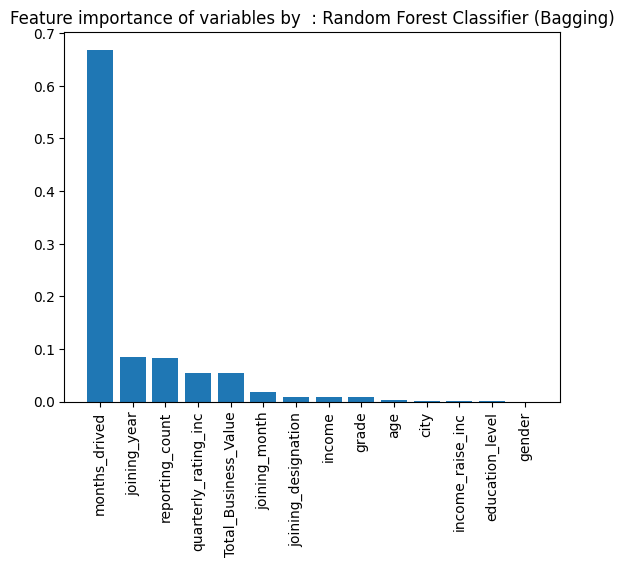

In [77]:
importances_rfc = model_rfc.feature_importances_
index = np.argsort(importances_rfc)[::-1]
col_names_rfc = [X.columns[i] for i in index]
plt.bar(range(X_sm.shape[1]), importances_rfc[index])
plt.xticks(range(X_sm.shape[1]),col_names_rfc, rotation = 90)
plt.title("Feature importance of variables by  : Random Forest Classifier (Bagging)")
plt.show()

This above plot shows that XGBoost performs slightly better over Bagging (Random Forest).